## University based topic analysis

In [1]:
from distfit import distfit
from pyfiles.mod_topic_influence_base import *

In [2]:
from scipy.signal import peak_widths, find_peaks

In [3]:
%store -r group_publication_titles
# %store -r topic_with_value
# %store -r topic_rank
# %store -r norm_distance_kl
# %store -r norm_distance_tau
%store -r mgp_nodes

In [4]:
%store -r lda_model
%store -r id2word
%store -r prepare_text_for_lda

In [5]:
# %store -r group_publication_titles
# %store -r topic_rank_value
# %store -r norm_distance_kl
# %store -r norm_distance_tau

In [6]:
def univ_wise_approach1(mgp_nodes, group_publication_titles, topic_rank_value):
    global lda_model
    global id2word
    global prepare_text_for_lda
    mgp_nodes["University"] = mgp_nodes["University"].fillna("")
    const_value = 1
    group_head_univ = [mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and ") 
                       for k,v in group_publication_titles.items() if len(v) > 0]
    #check once whether to keep split or not
    
    group_head_univ = [sublist for andlist in group_head_univ for sublist in andlist]
    top_topic_group_over_interval = [[topics[0] if topics[0] > 0.0 else None 
                                      for topics in intervals] for intervals in topic_rank_value]
    top_topic_over_group = [(univ, Counter(topics).most_common()[0][0]) 
                            for topics, univ in zip(top_topic_group_over_interval,group_head_univ)]
    univ_score = {}
    for univ, topic in top_topic_over_group:
        if univ in univ_score :
            univ_score[univ].append(topic)
        else:
            univ_score[univ] = []
            univ_score[univ].append(topic)
    univ_score      = [(univ, Counter(univ_score[univ]).most_common()[0]) for univ in univ_score]
    univ_freq       = Counter(group_head_univ)
    univ_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and "), v) 
                       for k,v in group_publication_titles.items() if len(v) > 0]
    univ_publ_tuple = [(sublist,v) for k,v in univ_publ_tuple for sublist in k]
    univ_publ1      = {}
    for univ, publ in univ_publ_tuple:
        if univ in univ_publ1:
            univ_publ1[univ].extend(publ)
        else:
            univ_publ1[univ] = publ
    univ_year = {univ:[year for publ,year in univ_publ1[univ]] for univ in univ_publ1}
    univ_yl   = {univ: max(univ_year[univ])-min(univ_year[univ]) for univ in univ_year}
    normalize_univ_score = [(key1, val1[1]/((univ_yl[key1]+const_value)*univ_freq[key1])) 
                            for key1, val1 in univ_score]
    sorted_normalize_univ_score =  sorted(normalize_univ_score, key=lambda x : x[1], reverse=True)
    return sorted_normalize_univ_score

In [7]:
#score = univ_wise_approach1(mgp_nodes, group_publication_titles, topic_rank)

In [8]:
#top_topic_over_group = [(country, Counter(topics).most_common()[0][1]/len(topics)) for topics,country in zip(top_topic_group_over_interval,group_head_country)]

In [9]:
#mgp_nodes[mgp_nodes["University"].str.contains(" and " ,na=False)]["University"].values[0].split(" andgg ")

In [10]:
def univ_wise_approach2(mgp_nodes, group_publication_titles):
    mgp_nodes["University"] = mgp_nodes["University"].fillna("")
    univ_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and "), v) for k,v in group_publication_titles.items() if len(v) > 0] #check once whether to keep split or not
    univ_publ_tuple = [(sublist,v) for k,v in univ_publ_tuple for sublist in k]
    univ_publ1 = {}
    for univ, publ in univ_publ_tuple:
        if univ in univ_publ1:
            univ_publ1[univ].extend(publ)
        else:
            univ_publ1[univ] = publ
    univ_publ1 = {country: [(" ".join([publ for publ, year in univ_publ1[country] if yr==year]),yr) for yr in sorted(set(univ_year[country]))] for country in univ_year}
    univ_publ = {univ:[publ for publ,year in univ_publ1[univ]] for univ in univ_publ1}
    univ_year = {univ:[year for publ,year in univ_publ1[univ]] for univ in univ_publ1}
    univ_yl   = {univ: max(univ_year[univ])-min(univ_year[univ]) for univ in univ_year}
    univ_topic_dist  =  {univ:predict(lda_model, id2word, prepare_text_for_lda, univ_publ[univ]) 
                         for univ in univ_publ}
    univ_top_topic_over_groups = {univ:[get_top_topic(topic) for topic in univ_topic_dist[univ]] 
                                  for univ in univ_topic_dist}
    univ_top_topic = {univ:Counter(univ_top_topic_over_groups[univ]).most_common()[0] 
                      for univ in univ_top_topic_over_groups}
    normalized_score = {univ:univ_top_topic[univ][1]/(univ_yl[univ]+1) for univ in univ_top_topic}
    sorted_normalized_score =  sorted(normalized_score.items(), key=lambda x:x[1], reverse=True)
    return (sorted_normalized_score,univ_top_topic_over_groups)

In [11]:
def univ_wise_approach3(mgp_nodes, group_publication_titles):
    global lda_model
    global id2word
    global prepare_text_for_lda
    Min_publ=0
#     lda_model, id2word = load_topic_model(topic_model, topic_dict, corpus)
#     lda_model.minimum_probability = 0.0
    num_topics= lda_model.num_topics
    mgp_nodes["University"] = mgp_nodes["University"].fillna("")
#     univ_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and "), v) for k,v in group_publication_titles.items() if len(v) > Min_publ]
    univ_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0], v) for k,v in group_publication_titles.items() if (len(v) > Min_publ and mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0]!="")]
    #univ_publ_tuple = [(sublist,v) for k,v in univ_publ_tuple for sublist in k]
    univ_publ1 = {}
    for univ, publ in univ_publ_tuple:
        if univ in univ_publ1:
            univ_publ1[univ].extend(publ)
        else:
            univ_publ1[univ] = publ
    #del univ_publ1["Business"]
    univ_year = {univ:[year for publ,year in univ_publ1[univ]] for univ in univ_publ1}
    university_publ = {university: [(" ".join([publ for publ, year in univ_publ1[university] if yr==year]),yr) for yr in sorted(set(univ_year[university]))] for university in univ_publ1}
    university = [k for k,v in university_publ.items() if len(v) > Min_publ]
    topic_distribution_year = [(topic_distributions_over_interval((k,v), lda_model, id2word,prepare_text_for_lda)) 
                               for k,v in university_publ.items() if len(v) > Min_publ]
    interval_start_year = [i[0] for i in topic_distribution_year]
    topic_distribution  = [i[1] for i in topic_distribution_year]
    aggregated_distribution_topic_rank = [aggregate_dist_over_interval(dist=dist, i=i, rank=True, no_of_topics= num_topics) for i, dist in enumerate(topic_distribution)]
    aggregated_distribution = [elem[0] for elem in aggregated_distribution_topic_rank]
    topic_with_value        = [elem[1] for elem in aggregated_distribution_topic_rank]
    topic_rank = [[[value[0] for value in interval] for interval in researcher] 
                  for researcher in topic_with_value] #changed
    metric_distance_kl = [get_distance_over_interval(dist, i, kl_divergance) 
                          for i, dist in enumerate(aggregated_distribution)]
    metric_distance_tau = [get_distance_over_interval(rank, i, modified_jaccard_index) 
                           for i, rank in enumerate(topic_rank)]
    norm_distance_kl    = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_kl]
    norm_distance_tau   = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_tau]
    assert len(interval_start_year) == len(aggregated_distribution) == len(metric_distance_kl) == len(metric_distance_tau) == len(university) == len(norm_distance_kl)==len(norm_distance_tau)
    return (university, interval_start_year, norm_distance_kl, norm_distance_tau)

In [12]:
wrap = lambda x : " ".join(x.split()[0:3]+["\n"]+x.split()[3:]) if len(x.split(" ")) > 3 else x

In [13]:
# res_metric        = dict([(head_metric[0],(head_metric[1],i))for i, head_metric in enumerate(zip(university, metric_std_kl))])
# res_metric1       = dict([(name, metric) for name, metric in zip(university, metric_std_kl)])
# sorted_res_metric = dict(sorted(res_metric1.items(), key= lambda x: x[1], reverse=True))

In [14]:
#country_top_topic_over_groups["UnitedStates"]

In [15]:
#score2, univ_top_topic_over_groups = univ_wise_approach2(mgp_nodes, group_publication_titles)

(array([1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 3.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ,
        14.2, 15.4, 16.6, 17.8, 19. ]),
 <BarContainer object of 15 artists>)

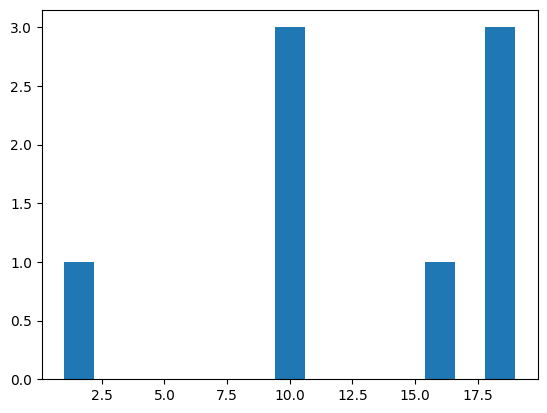

In [40]:
plt.hist(univ_top_topic_over_groups["University of Windsor"], bins=15)

In [41]:
fontsize=18

In [42]:
top_universities =   {wrap(k):v for k, v in score2[:10]}

In [43]:
top_universities

{'Stanford University': 106.84146341463415,
 'Université Pierre-et-Marie-Curie - \n Paris VI': 106.69811320754717,
 'University of California \n Berkeley': 99.17647058823529,
 'Université Paris-Sud XI \n - Orsay': 97.79629629629629,
 'Massachusetts Institute of \n Technology': 89.15294117647059,
 'Princeton University': 82.58163265306122,
 'University of Oxford': 70.0561797752809,
 'Lomonosov Moscow State \n University': 69.59,
 'Harvard University': 68.77272727272727,
 'Université Paris Diderot \n - Paris 7': 68.0}

In [44]:
top_population =   [mgp_nodes[mgp_nodes["University"]==k].shape[0] for k, v in score2[:10]]

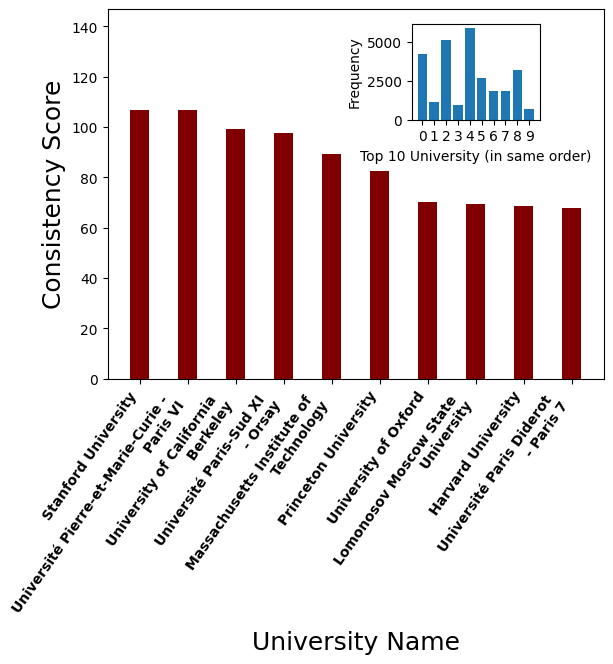

In [60]:
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.60, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(top_universities.keys(), top_universities.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(top_universities.keys(), rotation=55, ha='right',fontsize=fontsize-8, weight="bold")
ax1.set_ylim(0,np.max(list(top_universities.values()))+40)
ax2.bar(range(len(top_population)),top_population)
ax2.set_xticks(range(len(top_population)))
ax2.set_xlabel("Top 10 University (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)

ax1.set_xlabel("University Name",fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)
plt.savefig(f"{fig_folder}/top_10_university.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

In [53]:
# fig = plt.figure(figsize = (10, 8))
# plt.bar(top_universities.keys(), top_universities.values(), color ='orange', width = 0.4)

# plt.xticks(rotation=90, fontsize=fontsize-2, wrap=True)

# plt.xlabel("University Name",fontsize=fontsize)
# plt.ylabel("Consistency Score", fontsize=fontsize)
# plt.savefig(f"{fig_folder}/top_10_university.pdf",bbox_inches="tight")
# #plt.title("Students enrolled in different courses")
# plt.show()

In [54]:
#mgp_nodes["University"].value_counts()[:10]

In [55]:
score2[-10:][::-1]

[('Northern Illinois University', 0.02040816326530612),
 ('University of Massachusetts Lowell', 0.02127659574468085),
 ('University of North Carolina at Charlotte', 0.02127659574468085),
 ('University of Texas at Houston', 0.02564102564102564),
 ('Otto-Friedrich-Universität Bamberg', 0.02857142857142857),
 ('Institut National des Sciences Appliquées de Rouen', 0.03773584905660377),
 ('University of Setif', 0.03773584905660377),
 ('Moscow Engineering Physics Institute', 0.0392156862745098),
 ('City\t University of London', 0.04081632653061224),
 ('University of New Brunswick', 0.04081632653061224)]

In [37]:
#fig_folder

In [57]:
last_universities = {wrap(k):v for k, v in score2[-10:][::-1]}

In [58]:
last_population = [mgp_nodes[mgp_nodes["University"]==k].shape[0] for k, v in score2[-10:][::-1]]

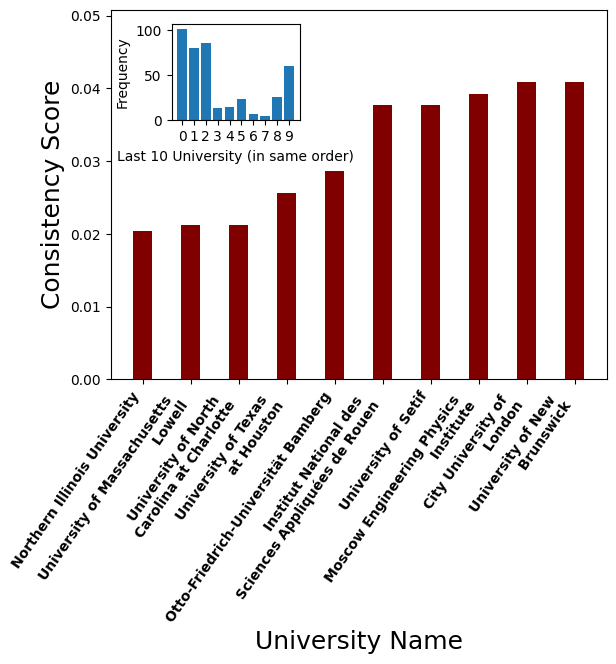

In [64]:
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.22, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(last_universities.keys(), last_universities.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(last_universities.keys(), rotation=55, ha='right',weight="bold")
ax1.set_ylim(0,np.max(list(last_universities.values()))+0.01)

ax2.bar(range(len(last_population)),last_population)
ax2.set_xticks(range(len(last_population)))
ax2.set_xlabel("Last 10 University (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)

ax1.set_xlabel("University Name",fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)
plt.savefig(f"{fig_folder}/last_10_university.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

In [72]:
# fig = plt.figure(figsize = (10, 8))
# plt.bar(last_universities.keys(), last_universities.values(), color ='orange', width = 0.4)

# plt.xticks(rotation=90,fontsize=fontsize-2,wrap=True)

# plt.xlabel("University Name", fontsize=fontsize)
# plt.ylabel("Consistency Score", fontsize=fontsize)
# plt.savefig(f"{fig_folder}/last_10_university.pdf",bbox_inches="tight")
# #plt.title("Students enrolled in different courses")
# plt.show()

### Thrid Approach

In [13]:
# def group_plot_metric(mgp_ids, year, metric_dist, researcher_id, name="", flag="", ylim=None):
#     if flag=="researcher":
#         txt= "MGP ID: "
#     else:
#         txt = ""
#     indexs =  [i for i, idd in enumerate(researcher_id) if idd in mgp_ids]
#     if len(indexs) > 0:
#         metric_dist = [[np.round(float(i), 2) for i in nested] for nested in metric_dist]
#         plt.figure(figsize=(8, 6), dpi=80)
#         for index in indexs:
            
#             if len(year[index][1:]) > 0:
#                 print(year[index])
#                 plt.plot(year[index][1:], metric_dist[index], label=f"{txt}{researcher_id[index]}",                             marker='o', markersize=5)
#             else:
#                 plt.plot(year[index], metric_dist[index], label=f"{txt}{researcher_id[index]}", marker='o',                     markersize=5)
#         plt.ylabel("Topic Distance Over Interval")#
#         plt.xlabel("Publication Year")
#         plt.ylim(ylim)
#         plt.legend()
#         plt.savefig(f"{fig_folder}/{name}.pdf")
#         plt.show()
#     else:
#         print(f"Advisor (Group leader : {mgp_id}) not present in the filtered dataset")
#     return

In [14]:
university, interval_start_year, norm_distance_kl, norm_distance_tau= univ_wise_approach3(mgp_nodes, group_publication_titles)

In [15]:
did1  = lambda x: abs(np.diff(x, len(x)-1)[0])/len(x) #difference in difference

In [16]:
did2  = lambda x: np.std(np.diff(x,2))*np.std(x)

In [17]:
did3  = lambda x: (np.std(np.diff(x,1))*np.std(x)) #/(len(find_peaks(x)[0])+0.000000001)

In [18]:
did   = lambda x: (np.std([abs(d) for d in np.diff(x,1)])*np.std(x))

In [19]:
#did = lambda x: np.sum([np.diff(p) for p in peak_widths(x, find_peaks(x)[0])])# rel_height=0.5

In [20]:
#did = lambda x:len(find_peaks(x)[0]

In [21]:
university[362]

'Athens University of Economics and Business'

In [22]:
did(norm_distance_kl[362])

0.0026582542

In [23]:
norm_distance_kl[362]

[0.31669158, 0.20285699, 0.1794946, 0.30095688]

In [24]:
#ll=list(group_publication_titles.items())

In [25]:
# With modified jaccard co-efficient MJC
metric_std_tau   = [did(interval) for interval in norm_distance_tau]

# with Kullback–Leibler divergence (KL-Divergance)
metric_std_kl   = [did(interval) for interval in norm_distance_kl]

#Peaks calculation for MJC And KLD
metric_peaks_tau = [len(find_peaks(interval)[0]) for interval in norm_distance_tau]
metric_peaks_kl = [len(find_peaks(interval)[0]) for interval in norm_distance_kl]

persistent_res_kl, anti_persistent_res_kl, res_kl = find_from_filtered_top_lowest(metric_std_kl, university, zero_include=False, top=10, index_between=(0,len(university)))

persistent_res_tau, anti_persistent_res_tau, res_tau = find_from_filtered_top_lowest(metric_std_tau, university, zero_include=False, top=10, index_between=(0,len(university)))

In [26]:
univ_metric= dict([(u,(0,i)) if pd.isna(m) else (u,(m,i)) for i, (u, m) in enumerate(zip(university, metric_std_kl))])

In [27]:
persistent_res_kl[:5]

['Universität Königsberg',
 'Universität Leipzig',
 'Tartu University',
 'Illinois Institute of Technology',
 'University of Hawaii']

In [28]:
univ_metric["University of North Carolina at Charlotte"]

(0.059758742652263636, 830)

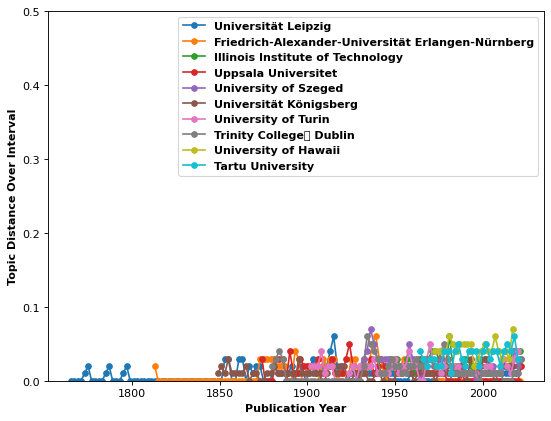

In [29]:
group_plot_metric(persistent_res_kl[:10], interval_start_year, norm_distance_kl, university, name="persistent_kl_university", flag="",ylim=(0,0.5))

In [30]:
#interval_start_year[0]

In [31]:
#interval_start_year[0]

In [32]:
wrap = lambda x : " ".join(x.split()[0:3]+["\n"]+x.split()[3:]) if len(x.split(" ")) > 3 else x

In [33]:
anti_persistent_res_kl1 = [wrap(county) for county in anti_persistent_res_kl]

In [34]:
anti_persistent_res_kl1

['University of Texas \n at Houston',
 'Universidade Estadual Paulista \n São Paulo',
 'Ulster University',
 'University of North \n Carolina at Charlotte',
 'University of New \n Brunswick',
 'Universität Kassel',
 'Aalborg Universitet',
 'Northern Illinois University',
 'Radcliffe College',
 'Kharkiv National University \n of Radioelectronics and Dnipro Polytechnic National Technical University']

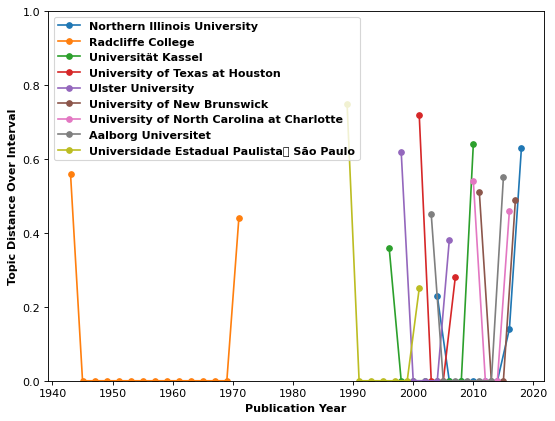

In [35]:
group_plot_metric(anti_persistent_res_kl[:9], interval_start_year, norm_distance_kl, university, name="anti_persistent_kl_university",ylim=(0,1))

In [30]:
anti_persistent_res_kl

['University of Texas at Houston',
 'Universidade Estadual Paulista\t São Paulo',
 'Ulster University',
 'University of North Carolina at Charlotte',
 'University of New Brunswick',
 'Universität Kassel',
 'Aalborg Universitet',
 'Northern Illinois University',
 'Radcliffe College',
 'Kharkiv National University of Radioelectronics and Dnipro Polytechnic National Technical University']

In [31]:
persistent_res_kl

['Universität Königsberg',
 'Universität Leipzig',
 'Tartu University',
 'Illinois Institute of Technology',
 'University of Hawaii',
 'University of Turin',
 'University of Szeged',
 'Uppsala Universitet',
 'Friedrich-Alexander-Universität Erlangen-Nürnberg',
 'Trinity College\t Dublin']